In [66]:
import numpy as np
from timeit import default_timer as timer
from colour import Color
from matplotlib import colors
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import gif

#CUSTOM CMAP
def customcmap(t_i, t_r):
    s = Color("#f5ebeb")
    i1 = Color("#5e0202")
    i2 = Color("#e81717")
    r1 = Color("#e8c917")
    r2 = Color("#e8db90")
    clist = [s] + list(i1.range_to(i2, t_i)) + list(r1.range_to(r2, t_r))
    clist = [c.hex for c in clist]
    
    return colors.ListedColormap(clist)


#PROPOGATOR FUNCTION
def propogator(tau_t,x_dim,y_dim,t_i,t_r,det_prob,r,w_sum):
    #looping through all the blocks (except the boundaries)
    
    t=tau_t.copy()  #use .copy() to prevent simaltaneous changes in both t and tau_t
    count=0
    
    for i in np.arange(r,x_dim+r):
        for j in np.arange(r,y_dim+r):
            
            #for susceptible individuals (Using MOORE Neighbourhood)
            if(tau_t[i][j]==0):    
                count=0
                probability=0   
                
                for k in np.arange(-r,r+1):
                    for l in np.arange(-r,r+1):
                        if(1<=tau_t[i+k][j+l]<=t_i and (k,l)!=(0,0)):
                            w=max(abs(k),abs(l)) #weight of each cell
                            count=count+(r-(w-1))
                
                probability=count/w_sum
                x=np.random.random()
                if(x<=probability*det_prob): #if det_prob=8, even a single infected neighbour can infect, for det_prob=1, we get the standard probabilistic model.
                    t[i][j]=1
                
            #for infected and refractory
            elif(1<=tau_t[i][j]<t_i+t_r):
                t[i][j]=t[i][j]+1
                
            #last stage (tau_0----->0)
            elif(tau_t[i][j]==t_i+t_r):
                t[i][j]=0
    #BOUNDARY CONDITIONS (just recovered after getting infected)
    i=0
    for i in range(r):                 #All borders of width = (radius) are fixed boundaries.
        t[:,i]=t_i+1
        t[i,:]=t_i+1
        t[:,y_dim+(2*r-(i+1))]=t_i+1
        t[x_dim+(2*r-(i+1)),:]=t_i+1
    
    return t


#for counting number of infected, refractory and susceptible individuals 
def datastats(state,x_dim, y_dim, t_i,t_r,r):
    inf=0
    ref=0
    sus=0
    for i in np.arange(r,x_dim+r):
        for j in np.arange(r,y_dim+r):
            if (state[i][j]==0):
                sus=sus+1
            if (1<=state[i][j]<=t_i):
                inf=inf+1
            if ((t_i+1)<=state[i][j]<=(t_i+t_r)):
                ref=ref+1
    
    return sus,inf,ref 
            
    

In [67]:
# (FOR A MIXED INITIAL POPULATION OF SUSCEPTIBLE AND INFECTED PEOPLE)

#INITIAL CONDITIONS


#Distribution of Initial Population

#p=0.00      # INITIAL FRACTION OF INFECTION

#tau_list=np.zeros(((x_dim + 2)*(y_dim + 2)), dtype=int)  

#for k in range ((x_dim + 2)*(y_dim + 2)):
#    rand=np.random.random()
#    if(0<=rand<p):
#        tau_list[k]=tau_list[k]+1
#    elif(p<=rand<=1):
#        tau_list[k]=tau_list[k]+0


In [96]:
#Randomly distributed initial population with only susceptible and refractory at different stages. Only one infected in the middle.
#leads to persisting infection waves.


#MAIN PROGRAM

#parameters

radius=1
det_prob=1   #Deterministic((2*radius+1)**2 -1) or Probablistic(1) Automata
t_i=4                           # 1<=t<=t_i is the infected range
t_r=7                           # t_i+1<=t<=t_i+t_r is the refractory range
x_dim=100
y_dim=100
time=100
cmap = customcmap(t_i, t_r)
suslist=[]
inflist=[]
reflist=[]
tarray=np.arange(time)

#total weight due to r!=1
weight_sum=0
for a in np.arange(1,radius+1):
    weight_sum = weight_sum + ((radius-(a-1))*(8*a))

#INITIAL CONDITIONS


#Distribution of Initial Population

tau_list=np.zeros(((x_dim + 2*radius)*(y_dim + 2*radius)), dtype=int)  
p_ref=0.5  #initial percentage of refractory population

#for k in range ((x_dim + 2*radius)*(y_dim + 2*radius)):
#    rand=(np.random.random())
#    if(0<=rand<=p_ref):
#        rand2=int(np.random.randint(low=1,high=7))
#        tau_list[k]=tau_list[k]+rand2+t_i
    
tau=np.reshape(tau_list,(x_dim+2*radius,y_dim+2*radius))


#BOUNDARY CONDITIONS 
i=0
for i in range(radius):                 #All borders of width = (radius) are fixed boundaries.
    tau[:,i]=t_i+1
    tau[i,:]=t_i+1
    tau[:,y_dim+(2*radius-(i+1))]=t_i+1
    tau[x_dim+(2*radius-(i+1)),:]=t_i+1

tau[(x_dim+2*radius)//3,(y_dim+2*radius)//3]=1     #single infection in the middle


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


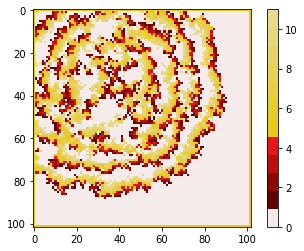

In [97]:
start = timer()
fig=plt.figure()
state=tau.copy()
plt.colorbar(plt.imshow(state, cmap=cmap, interpolation = 'nearest', vmin = 0, vmax = t_i+t_r))
ims=[] 
im=plt.imshow(state, animated=True, cmap = cmap, vmin = 0, vmax = t_i+t_r)
ims.append([im])
for t in range(time):
        
    sus,inf,ref=datastats(state, x_dim, y_dim, t_i, t_r, radius)
    suslist.append(sus)
    inflist.append(inf)
    reflist.append(ref)
    state_new=propogator(state,x_dim,y_dim,t_i,t_r,det_prob,radius,weight_sum)
    state=state_new.copy()
    if(t%1==0):
        im=plt.imshow(state, animated=True, cmap = cmap, vmin = 0, vmax = t_i+t_r)
        ims.append([im])      
ani=animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
ani.save('SIRSmodel_rand.gif', writer='imagemagick', fps=5)
#check for changes on github
end = timer()


Runtime   20.996077299998433


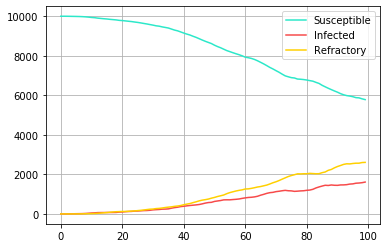

Susceptible = 5782
Infected = 1611
Refractory = 2607


In [98]:
print("Runtime  ",end-start)
plt.plot(tarray, suslist,'#2ce8c9', label="Susceptible")
plt.plot(tarray, inflist,'#f74a4a', label="Infected")
plt.plot(tarray, reflist,'#ffd000', label="Refractory")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
print("Susceptible =", suslist[time-1])
print("Infected =", inflist[time-1])
print("Refractory =", reflist[time-1])

In [ ]:
#for counting number of infected, refractory and susceptible individuals 
def datastats(state,x_dim, y_dim, t_i,t_r):
    inf=0
    ref=0
    sus=0
    for i in np.arange(1,x_dim+1):
        for j in np.arange(1,y_dim+1):
            if (state[i][j]==0):
                sus=sus+1
            if (1<=state[i][j]<=t_i):
                inf=inf+1
            if ((t_i+1)<=state[i][j]<=(t_i+t_r)):
                ref=ref+1
    
    return sus,inf,ref 
            
    

In [41]:
np.arange(-1,2)

array([-1,  0,  1])

In [43]:
a=0
b=1
(a,b)==(0,0)

False

In [48]:
max(abs(-1), abs(-2))

2